# Time of Response and Practicing Effect

---
## 1. Introduction

The main difference of responding the SDMT test on paper and responding on digital is thet the second one we have the precise moment every patient performs a task, so we might discover new features as time.

We are interested on analyse the time of response every participant have, in addition, we want to check the practicing effect on trials over the time

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [2]:
sys.path.insert(0, '/Users/pedrohserrano/SDMT-Analysis/utils') #internal packages
import buildms as ms 
import statsms as stms
color_ms = '#386cb0' #blue, This is the color chosen for patients with Multiple Sclerosis
color_hc = 'red'#This is the color chosen for health control participants

--- 
##### Loading Datasets

In [3]:
!python ~/SDMT-Analysis/utils/create_dataset.py ~/SDMT-Analysis/data/processed/mijn-kwik-may.csv

Percetnage of missing values: 26.309124185727793
Max answers: 61
Min score: 7 Max score: 67 Mean score: 45.861979166666664
Percentage of MS in Dataset: 65.0 %
... Dataset df_measures_users.csv created
... Dataset df_measures.csv created
... Dataset df_symbols.csv created


In [4]:
df_measures = pd.read_csv('~/SDMT-Analysis/data/interim/df_measures.csv', encoding="utf-8")

In [5]:
df_measures_users = pd.read_csv('~/SDMT-Analysis/data/interim/df_measures_users.csv', encoding="utf-8")

In [6]:
df_symbols = pd.read_csv('~/SDMT-Analysis/data/interim/df_symbols.csv', encoding="utf-8") 

In [14]:
score_variable = 'avg_test_ms'

---
## 2. Methods

### 2.1 Expected Time per Person

In general we might say that each person has its own distribution regarding on time of response, and that distribution has a mean and median, so as a first feautre we found the expected time on every patient.

In [15]:
scores_sorted = df_measures_users.set_index('userId')[score_variable].sort_values(ascending=False)
ms_labels = [df_measures[df_measures['userId']==user].iloc[0]['ms'] for user in scores_sorted.index]
colores = [color_ms if ms==1 else color_hc for ms in ms_labels]

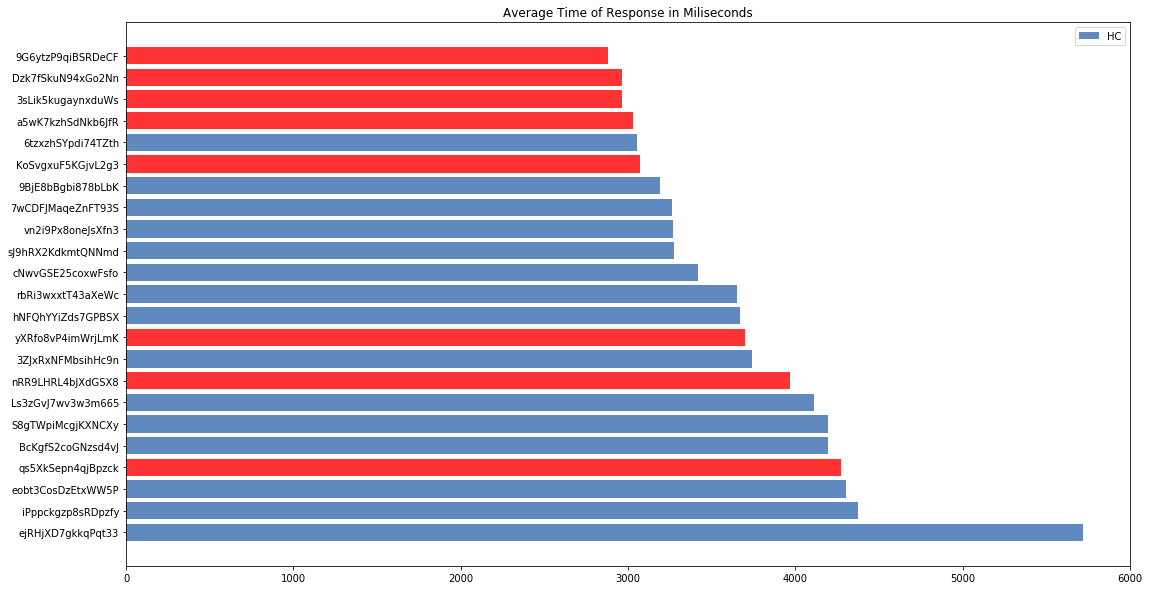

In [21]:
plt.figure(figsize=(18, 10))
position = range(len(scores_sorted.index))
plt.barh(position, scores_sorted, align='center', alpha=0.8, color=colores, label='HC')
plt.yticks(position, scores_sorted.index)
plt.legend(loc='best')
plt.title('Average Time of Response in Miliseconds')
plt.show()

As we can see the people on MS (blue) tend to be more slow in their answers. It is natural to see that the average time of response is negative correlated with the scores ever since every test is performed on exactly 90 seconds.

Using the same logic we may think on an average time of response of every group, as we see in the table below, the people on Health Control, is half second faster on average, so allow them to score more on 90 seconds

|Group|Average Time of Response|
|:--:|:--:|
|MS|3.82 Seconds|
|HC|3.35 Seconds|

### 2.2 Expected Time per Symbol

What if the time a person needs to respond a task depends on the figure showed on the application, the goal on this section is trying to find any difference on the time elapsed depending on the symbols.

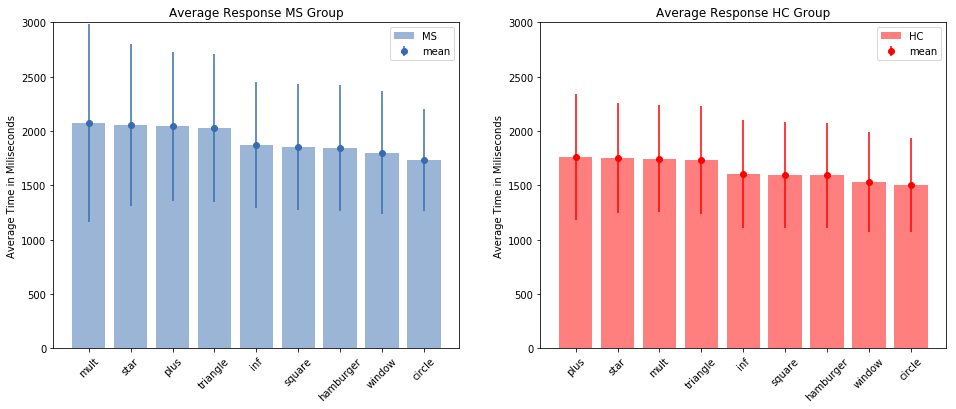

In [24]:
plt.figure(figsize=(16, 6))

symbols_ms = df_symbols[df_symbols['ms']==1].groupby(['symbol'])['response_ms'].describe()
symb_ms = symbols_ms['mean'].sort_values(ascending=False)
plt.subplot(1,2,1)
position_ms = range(len(symb_ms.index))
plt.title('Average Response MS Group')
plt.ylabel('Average Time in Miliseconds')
plt.bar(position_ms, symb_ms, align='center', alpha=0.5, color=color_ms, label='MS'); plt.ylim(0, 3000)
plt.errorbar(position_ms, symb_ms, yerr=symbols_ms['std'].sort_values(ascending=False).values, fmt='o',color=color_ms)
plt.xticks(position_ms, symb_ms.index.values, rotation=45); plt.legend()

symbols_hc = df_symbols[df_symbols['ms']==0].groupby(['symbol'])['response_ms'].describe()
symb_hc = symbols_hc['mean'].sort_values(ascending=False)
plt.subplot(1,2,2)
position_hc = range(len(symb_hc.index))
plt.title('Average Response HC Group')
plt.ylabel('Average Time in Miliseconds')
plt.bar(position_hc, symb_hc, align='center', alpha=0.5, color=color_hc, label='HC'); plt.ylim(0, 3000)
plt.errorbar(position_hc, symb_hc, yerr=symbols_hc['std'].sort_values(ascending=False).values, fmt='o' ,color=color_hc)
plt.xticks(position_hc, symb_hc.index.values, rotation=45); plt.legend()
plt.show()

As we see on the section 2.1, the Health Control group tend to be faster, the plots above shows this difference but also shows that there is a clear step on speed on each symbol, the order of the velocity tend to be the same. 

It is notizable that circle is the "easiest" to learn on any case

|Order |1|2|3|4|5|6|7|8|9|
|--|--|--|--|--|--|--|--|--|
|MS|**Mult**|Star|**Plus**|Triangle|Inf|Square|Hamburger|Window|Circle|
|HC|**Plus**|Star|**Mult**|Triangle|Inf|Square|Hamburger|Window|Circle|

So we might infer that does not matter if a person is MS or not, the speed to respond every symbols has kind of the same order of difficulty. In addition is clear to see that there is an important difference after the trianlge.

It looks like that there is 2 levels of effort when a patient use a cognition to process every digit and symbols, we might split on: "Easy Symbols" (Inf, Square, Hamburger, Window, Circle) and "Hard Symbols" (Plus, Star, Mult).

We should statistically prove this assumption trying to see if there is a significall difference.

In [31]:
df_symbols['difficulty']  = [
    'hard' if i in ['triangle','plus','star','mult'] else 'easy' for i in df_symbols['symbol']]

In [32]:
ms_easy = df_symbols[(df_symbols['difficulty']=='easy') & (df_symbols['ms']==1)]
ms_hard = df_symbols[(df_symbols['difficulty']=='hard') & (df_symbols['ms']==1)]
hc_easy = df_symbols[(df_symbols['difficulty']=='easy') & (df_symbols['ms']==0)]
hc_hard = df_symbols[(df_symbols['difficulty']=='hard') & (df_symbols['ms']==0)]

In [34]:
d1 = stms.dCohen(ms_easy['response_ms'], ms_hard['response_ms']).effect_size()
d2 = stms.dCohen(hc_easy['response_ms'], hc_hard['response_ms']).effect_size()
print('Cohen´s d-value: \n MS: {} Small \n HC: {} Small'.format(round(d1,3),round(d2,3)))

Cohen´s d-value: 
 MS: 0.35 Small 
 HC: 0.366 Small


Ever since the d-Cohen value to measure the effect size between the easy symbols and the hard symbols are small, we can not use this as a feature because the statisticla difference is small

### 2.3 Median Time of Response

When one is measuring the time as a variable is natural to ask the evolution over the experiment, in other words: Do the patients are getting slower, faster or any of those?  

It is possible to plot the time of response, in order to know the evolution of the time, the most acurate statistic to measure the 50% percentil of time performed on every test we take the median, and then calculate the SD.

We have to focus on the median over the time and its variance, is it possible that if they are getting faster then we should prove a **practicing effect** assumption

In [35]:
medians = df_symbols.groupby(['userId','timestamp'])['response_ms_med'].mean().reset_index()
stds = df_symbols.groupby(['userId','timestamp'])['response_ms'].std().reset_index()
medians['std'] = stds['response_ms'].values

In [36]:
ms_label = list(zip(df_measures_users['userId'], [color_ms if ms==1 else color_hc for ms in df_measures_users['ms']]))

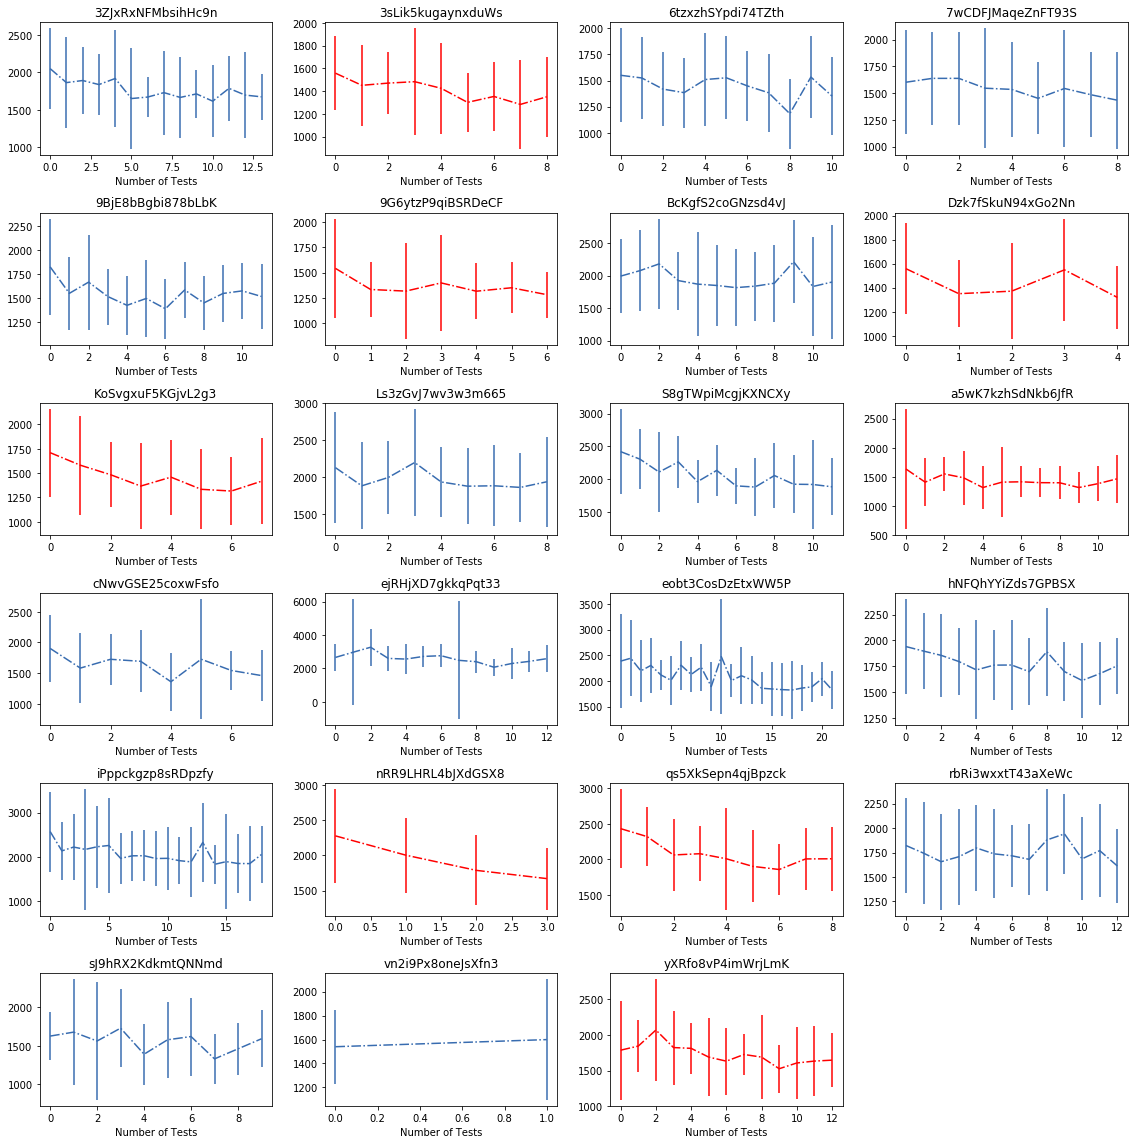

In [37]:
plt.figure(figsize=[16, 16])
for idx,i in enumerate(ms_label):
    plt.subplot(6,4,idx+1)
    medians_user = medians[medians['userId']==str(i[0])]
    plt.errorbar(range(len(medians_user)), medians_user['response_ms_med'], yerr=medians_user['std'], color=str(i[1]), linestyle='-.')
    plt.xlabel('Number of Tests')
    plt.title(str(i[0]))

plt.tight_layout()

As we see in the plots above, it seems they are learning, but they are not getting more variance, so they 

---
## 3. Practicing Effect

### 3.1 Effect on Median Time of Response

We should find if there is statistical difference on the first median time a person performed and the last median time the person performed, we use the d-Cohen value to find an effect split on MS and HC groups

In [40]:
first_med, last_med = [], []
for i in df_measures_users['userId']:
    user = medians[medians['userId']==str(i)]
    first_med.append(user['response_ms_med'].head(1).values[0])
    last_med.append(user['response_ms_med'].tail(1).values[0])

table_med = {}
for i in range(len(df_measures_users['userId'])):
    table_med[i] = (first_med[i], last_med[i])

med_users = pd.DataFrame(table_med).transpose()
med_users.columns = ['first_med', 'last_med']
med_users['userId'] = df_measures_users['userId'].values
med_users['ms'] = df_measures_users['ms'].values

In [43]:
ms_med = med_users[med_users['ms']==1]
hc_med = med_users[med_users['ms']==0]

If taken all the MS and HC scores and compares the first median vs the last median we can have the d value

In [44]:
d1 = stms.dCohen(ms_med['first_med'], ms_med['last_med']).effect_size()
d2 = stms.dCohen(hc_med['first_med'], hc_med['last_med']).effect_size()
print('Cohen´s d-value, First Median vs Last Median: \n MS: {} Large \n HC: {} Large'.format(round(d1,3),round(d2,3)))

Cohen´s d-value, First Median vs Last Median: 
 MS: 0.754 Large 
 HC: 0.974 Large


There is a large effect between the first against the last time performed, on Health Control group is even bigger, so it means they learn even more

In [45]:
def rate_change(value):
    pct = value * 100
    sign = '+' if pct > 0 else ''
    return '{}{:,.0f}%'.format(sign, pct)

In [46]:
change = (med_users['last_med']-med_users['first_med'])/med_users['first_med']
med_users['rate_change'] = change.map(rate_change)

In [47]:
med_users.sort_values('rate_change')

,first_med,last_med,userId,ms,rate_change
21,1540.0,1599.5,vn2i9Px8oneJsXfn3,1.0,+4%
11,1634.0,1466.0,a5wK7kzhSdNkb6JfR,0.0,-10%
3,1601.0,1433.0,7wCDFJMaqeZnFT93S,1.0,-10%
15,1941.5,1757.0,hNFQhYYiZds7GPBSX,1.0,-10%
19,1822.5,1613.0,rbRi3wxxtT43aXeWc,1.0,-11%
1,1558.0,1350.0,3sLik5kugaynxduWs,0.0,-13%
2,1550.0,1351.0,6tzxzhSYpdi74TZth,1.0,-13%
7,1558.0,1319.0,Dzk7fSkuN94xGo2Nn,0.0,-15%
4,1825.5,1518.5,9BjE8bBgbi878bLbK,1.0,-17%
5,1541.5,1282.0,9G6ytzP9qiBSRDeCF,0.0,-17%


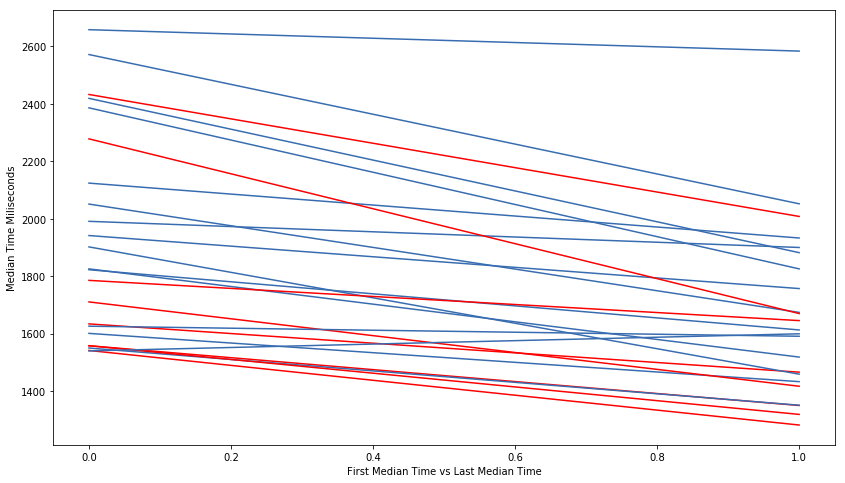

In [48]:
plt.figure(figsize=[14, 8])
colores = [color_ms if ms==1 else color_hc for ms in df_measures_users['ms']]
for idx, i in enumerate(colores):
    plt.plot(range(2), med_users[['first_med','last_med']].iloc[idx:idx+1].values[0], color=i)
    
plt.xlabel('First Median Time vs Last Median Time')
plt.ylabel('Median Time Miliseconds')

- In the literature shows that exist practicing effect and more significant after longer testing period
- Not influenced by gender, age, relapses, disability progression and prior natalizumab treatment
- They conclude that the practicing effect is less if they are more impaired on the EDSS scale

### 3.2 Effect on Scores

Comparing the same patient's numbers before and after treatment, we are effectively using each patient as their own control. That way the correct rejection of the null hypothesis (here: of no difference made by the treatment) can become much more likely, with statistical power increasing simply because the random between-patient variation has now been eliminated

$$ 
H_0: \mu_1 = \mu_2 \hspace{1cm}  \\
H_a: \mu_1 \ne \mu_2  \hspace{1cm} 
$$

Let's conduct a paired t-test to see whether this difference is significant at a 95% confidence level

**We take the scores performed on the Test-Retest experimentm also the information of the last scores performed**

In [54]:
import scipy.stats as stats

In [55]:
group = df_measures_users['userId'].tolist()

In [56]:
ms_builder = ms.MSscores(df_measures)

In [57]:
df_scores = ms_builder.scores_table(score_variable, group)
df_scores['ms'] = df_measures_users['ms']
df_scores_ms = df_scores[df_scores['ms']==1]
df_scores_hc = df_scores[df_scores['ms']==0]

Average Days Between Test-retest: 14.7 (SD): 3.21


In [58]:
df_firstlast = ms_builder.scores_first_last(score_variable, group)
df_firstlast['ms'] = df_measures_users['ms']
df_firstlast_ms = df_firstlast[df_firstlast['ms']==1]
df_firstlast_hc = df_firstlast[df_firstlast['ms']==0]

Average Days Between First and Last: 28.91 (SD): 8.62


##### MS Group

In [59]:
d1 = stms.dCohen(df_scores_ms['test'],df_scores_ms['re-test']).effect_size()
print('Average Score of MS Group: \n 1rs Test: {} (SD {}) \n 2nd Test: {} (SD {}) \nCohen`s d-value: {}  '.format(
    round(df_scores_ms['test'].mean(),2), round(df_scores_ms['test'].std(),2),
    round(df_scores_ms['re-test'].mean(),2), round(df_scores_ms['re-test'].std(),2),round(d1,3)),
     stats.ttest_rel(df_scores_ms['test'],df_scores_ms['re-test']))

Average Score of MS Group: 
 1rs Test: 4186.53 (SD 803.87) 
 2nd Test: 3804.8 (SD 665.91) 
Cohen`s d-value: 0.517   Ttest_relResult(statistic=3.0907794408741855, pvalue=0.0079771479579275259)


In [60]:
d2 = stms.dCohen(df_firstlast_ms['first'],df_firstlast_ms['last']).effect_size()
print('Average Score of MS Group: \n First: {} (SD {}) \n Last: {} (SD {}) \nCohen`s d-value: {}  '.format(
    round(df_firstlast_ms['first'].mean(),2), round(df_firstlast_ms['first'].std(),2),
    round(df_firstlast_ms['first'].mean(),2), round(df_firstlast_ms['first'].std(),2),round(d2,3)),
     stats.ttest_rel(df_firstlast_ms['first'],df_firstlast_ms['last']))

Average Score of MS Group: 
 First: 4186.53 (SD 803.87) 
 Last: 4186.53 (SD 803.87) 
Cohen`s d-value: 0.415   Ttest_relResult(statistic=1.8857346298735858, pvalue=0.08025248219045418)


##### HC Group

In [61]:
d3 = stms.dCohen(df_scores_hc['test'],df_scores_hc['re-test']).effect_size()
print('Average Score of HC Group: \n 1rs Test: {} (SD {}) \n 2nd Test: {} (SD {}) \nCohen`s d-value: {}  '.format(
    round(df_scores_hc['test'].mean(),2), round(df_scores_hc['test'].std(),2),
    round(df_scores_hc['re-test'].mean(),2), round(df_scores_hc['re-test'].std(),2),round(d3,3)),
     stats.ttest_rel(df_scores_hc['test'],df_scores_hc['re-test']))

Average Score of HC Group: 
 1rs Test: 3798.62 (SD 631.04) 
 2nd Test: 3323.0 (SD 551.9) 
Cohen`s d-value: 0.802   Ttest_relResult(statistic=4.0319049507566387, pvalue=0.0049837428574777331)


In [62]:
d4 = stms.dCohen(df_firstlast_hc['first'],df_firstlast_hc['last']).effect_size()
print('Average Score of HC Group: \n First: {} (SD {}) \n Last: {} (SD {}) \nCohen`s d-value: {}  '.format(
    round(df_firstlast_hc['first'].mean(),2), round(df_firstlast_hc['first'].std(),2),
    round(df_firstlast_hc['first'].mean(),2), round(df_firstlast_hc['first'].std(),2),round(d4,3)),
     stats.ttest_rel(df_firstlast_hc['first'],df_firstlast_hc['last']))

Average Score of HC Group: 
 First: 3798.62 (SD 631.04) 
 Last: 3798.62 (SD 631.04) 
Cohen`s d-value: 1.037   Ttest_relResult(statistic=7.2046556647300388, pvalue=0.00017673972602611743)


 The p-value in the test output shows that the chances of seeing this large of a difference between times due to chance is just over p%.
Si hay 

It seems that HC are learning

RELIABILITY WITH MEDIAN TIME OF RESPONSE